# Surface and flow

In this notebook, I develop tools for analyzing the simultaneous measurements of surface profile and flow field. The surface measurement is done with Keyence displacement sensor, of which the data processing is described in [Surface_profile.ipynb](Surface_profile.ipynb). Here, I focus on (i) getting flow field from tracers, (ii) register (synchronize, make correspondence ...) images with surface measurement data, (iii) get the point of laser focus from images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'

## 1 Load video

In [25]:
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # by default opencv reads images as BGR, here we convert to RGB to be compatible with matplotlib
    break

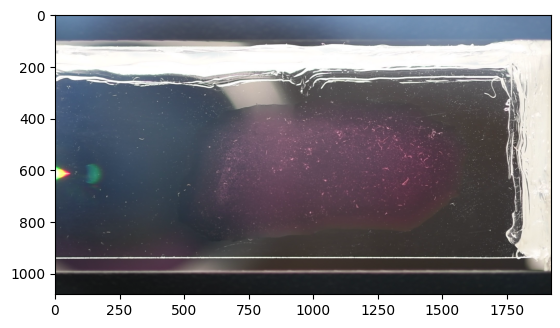

In [26]:
plt.imshow(frame)

## 2 Verify scanner speed

Since the scanner moves almost at a constant speed, a frame-by-frame tracking is an overkill. Instead, we can use two key frames at the beginning and the end of each scan, and infer the framewise location of the scanner, or the focus of the scanner. 

The key frame xy location is obtained from ImageJ and the frame number is obtained from MPC player (get time and convert to frame number).

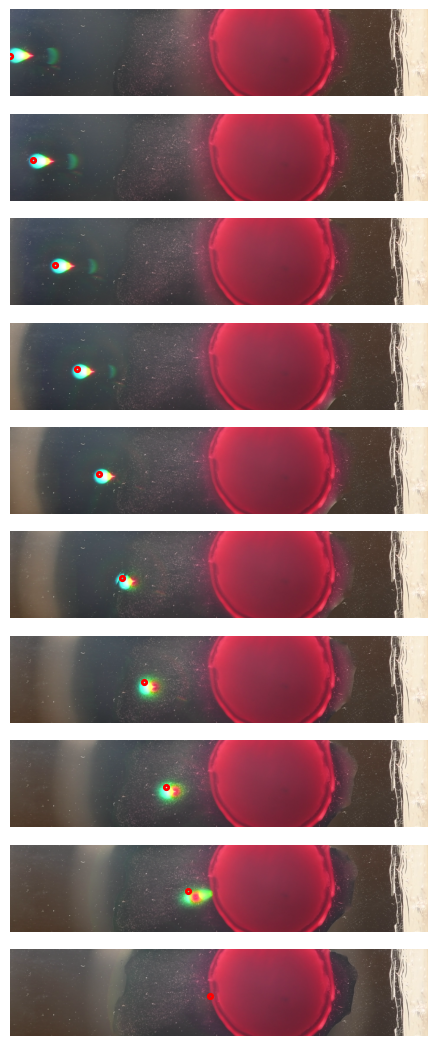

In [35]:
# eye tracking 942@(1,614), 2099@(921,614)
# draw 10 pictures with dot indicator on raw image
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
i = 0
fps = 30
num_draw = 10
show = np.linspace(12.879*fps, 28.428*fps, endpoint=True, num=num_draw).astype("int")
x = np.linspace(1, 921, endpoint=True, num=num_draw)
y = np.ones(x.shape) * 614
count = 0
# initialize figure
fig, ax = plt.subplots(ncols=1, nrows=num_draw, figsize=(1980/300, 400*num_draw/300), dpi=100)
while True:
    ret, frame = cap.read()  
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    i += 1
    if i in show:
        ax[count].imshow(frame[400:800, :])
        ax[count].scatter(x[count], y[count]-400, s=10, facecolor=(0,0,0,0), edgecolor="red", linewidths=2)
        ax[count].axis("off")
        count += 1

The scanner can be approximated as moving at a constant speed.

## 3 Synchronize profiler with videos

We do this by registering key frames.

### 3.1 Find the starting point in surface data and video

In [41]:
surface = pd.read_csv(r"E:\WPM\04292024\beet_scan_1.csv", usecols=[1], skiprows=12, names=["height"])

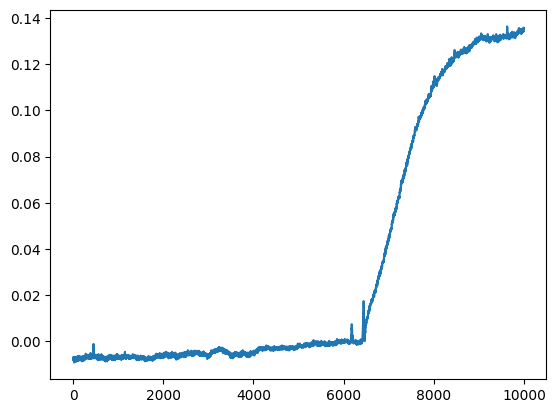

In [44]:
plt.plot(surface[:10000].height)


For video, we watch the video and find the time when laser spot touches the contact line. Then we can register the two times in a .csv file:

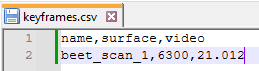

### 3.2 Make a demo

In [68]:
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan_1.MOV")
save_folder = r"E:\WPM\04292024\scan_demo"
i = 0
fps = 30

start_frame = (19.917 - 6300/1000) * 30
while True:
    ret, frame = cap.read()  
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    i += 1
    if i < start_frame:
        continue
    fig, ax = plt.subplots(ncols=1, nrows=2, dpi=100)
    ax[0].imshow(frame[200:800, :])
    ax[0].axis("off")
    data_end = int((i-start_frame)/fps*1000)
    ax[1].plot(surface[:data_end])
    ax[1].set_xlim([0, data_end])
    ax[1].set_ylim([-0.1, 0.5])
    plt.savefig(os.path.join(save_folder, "{:04d}.jpg".format(i)))
    plt.close()

### 3.3 Another demo

In this demo, I plot the film thickness as a function of the horizontal location $x$, instead of time. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

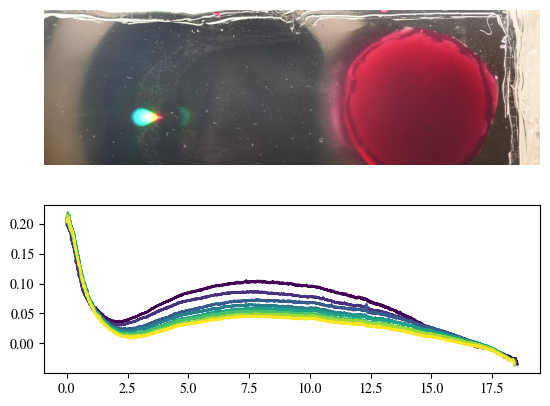

In [10]:
cap = cv2.VideoCapture(r"E:\WPM\04292024\beet_scan4_4.MOV")
data = pd.read_csv(r"E:\WPM\04292024\surface_profile\beet_scan4_4.csv")
keyframes = pd.read_csv(r"E:\WPM\04292024\keyframes.csv")
keyframes = keyframes.loc[keyframes["name"]=="beet_scan4_4"].reset_index()
save_folder = r"E:\WPM\04292024\scan_demo"
cmap = plt.get_cmap("viridis", 8)
datalen = len(data)
i = 0
j = 0
fps = 30

while True:
    ret, frame = cap.read() 
    i += 1
    # if i < 554:
    #     continue
     
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(ncols=1, nrows=2, dpi=100)
    ax[0].imshow(frame[200:800, :])
    ax[0].axis("off")
    step = i / fps * 1000 - 10496

    for k in range(j):
        ax[1].plot(data.x, data["scan-{:d}".format(k+1)], color=cmap(k), label=k)

    fraction = (step - keyframes.at[j, "start"]) / (keyframes.at[j, "end"] - keyframes.at[j, "start"])
    if fraction > 0:
        if keyframes.at[j, "direction"] == "f":
            ax[1].plot(data.loc[int(datalen*(1-fraction)):, "x"], data.loc[int(datalen*(1-fraction)):, "scan-{:d}".format(j+1)], color=cmap(j), label=j)
        else:
            ax[1].plot(data.loc[:int(datalen*fraction), "x"], data.loc[:int(datalen*fraction), "scan-{:d}".format(j+1)], color=cmap(j), label=j)

    if step >= keyframes.at[j, "end"]:
        j += 1
    if j >= 8:
        break
    
    
    # ax[1].plot(surface[:data_end])
    ax[1].set_xlim([0, 16])
    ax[1].set_ylim([0, 0.5])
    plt.legend(fontsize=8, frameon=False)
    plt.savefig(os.path.join(save_folder, "{:04d}.jpg".format(i)))
    plt.close()

In [9]:
17.317-6.821

10.496

## 4 Extract surface profile according to keyframes data

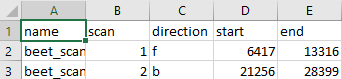

In [88]:
# read keyframes
keyframes = pd.read_csv(r"E:\WPM\04292024\keyframes.csv")
surface = pd.read_csv(r"E:\WPM\04292024\beet_scan_1.csv", usecols=[1], skiprows=12, names=["height"])

C:\Users\zl948\AppData\Local\Temp\ipykernel_107612\3617856999.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scan["x"] = np.flip(np.arange(len(scan))) / fps_data * v
C:\Users\zl948\AppData\Local\Temp\ipykernel_107612\3617856999.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scan.sort_values(by=["x"], inplace=True)
C:\Users\zl948\AppData\Local\Temp\ipykernel_107612\3617856999.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

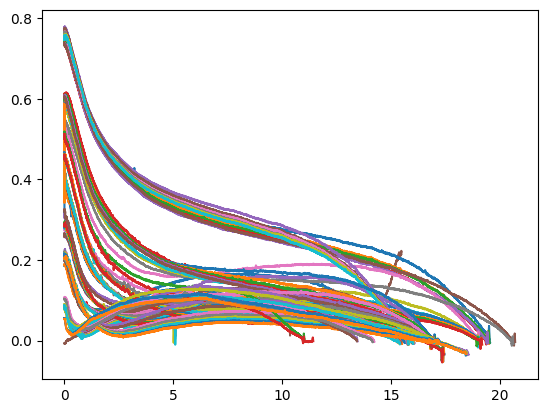

In [95]:
# extract surface profiles
folder = r"E:\WPM\04292024"
keyframes = pd.read_csv(os.path.join(folder, "keyframes.csv"))
save_folder = r"E:\WPM\04292024\surface_profile"
v = 1.6 # mm/s, I set it constant for now, but later this can be improved by measuring the speed for each specific scan
fps_data = 1000
for name, scans in keyframes.groupby("name"):
    surface = pd.read_csv(os.path.join(folder, "{}.csv".format(name)), usecols=[1], skiprows=12, names=["height"])
    scans_list = []
    for num, i in scans.iterrows():
        scan = surface[i.start: i.end]
        if i.direction == "f":
            scan["x"] = np.flip(np.arange(len(scan))) / fps_data * v
        else:
            scan["x"] = np.arange(len(scan)) / fps_data * v 
        scan.sort_values(by=["x"], inplace=True)
        plt.plot(scan["x"], scan["height"])
        scans_list.append(scan.set_index("x").rename(columns={"height": "scan-{:d}".format(i.scan)}))
    pd.concat(scans_list, axis=1).to_csv(os.path.join(save_folder, "{}.csv".format(name)))

In [85]:
scans_list

[         scan-1
 x              
 11.0368  0.0002
 11.0352  0.0005
 11.0336  0.0010
 11.0320  0.0013
 11.0304  0.0020
 ...         ...
 0.0064   0.5189
 0.0048   0.5138
 0.0032   0.5181
 0.0016   0.5166
 0.0000   0.5163
 
 [6899 rows x 1 columns],
          scan-2
 x              
 0.0000   0.5130
 0.0016   0.5135
 0.0032   0.5115
 0.0048   0.5002
 0.0064   0.5117
 ...         ...
 11.4208  0.0015
 11.4224  0.0000
 11.4240  0.0000
 11.4256 -0.0008
 11.4272 -0.0016
 
 [7143 rows x 1 columns]]

## 5 Profile vs. thickness

(0.0, 0.5)

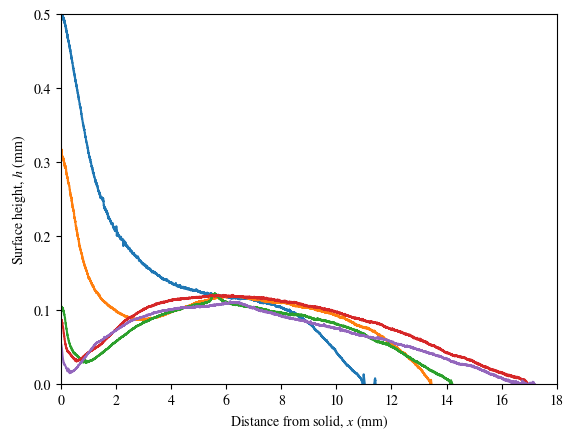

In [10]:
folder = r"E:\WPM\04292024\surface_profile"
plt.figure(dpi=100)
for i in range(1, 6):
    df = pd.read_csv(os.path.join(folder, "beet_scan_{:d}.csv".format(i))).set_index("x")
    plt.plot(df.index, df.mean(axis=1))
plt.xlabel("Distance from solid, $x$ (mm)")
plt.ylabel("Surface height, $h$ (mm)")
plt.xlim([0, 18])
plt.ylim([0, 0.5])

## 6 Temporal evolution

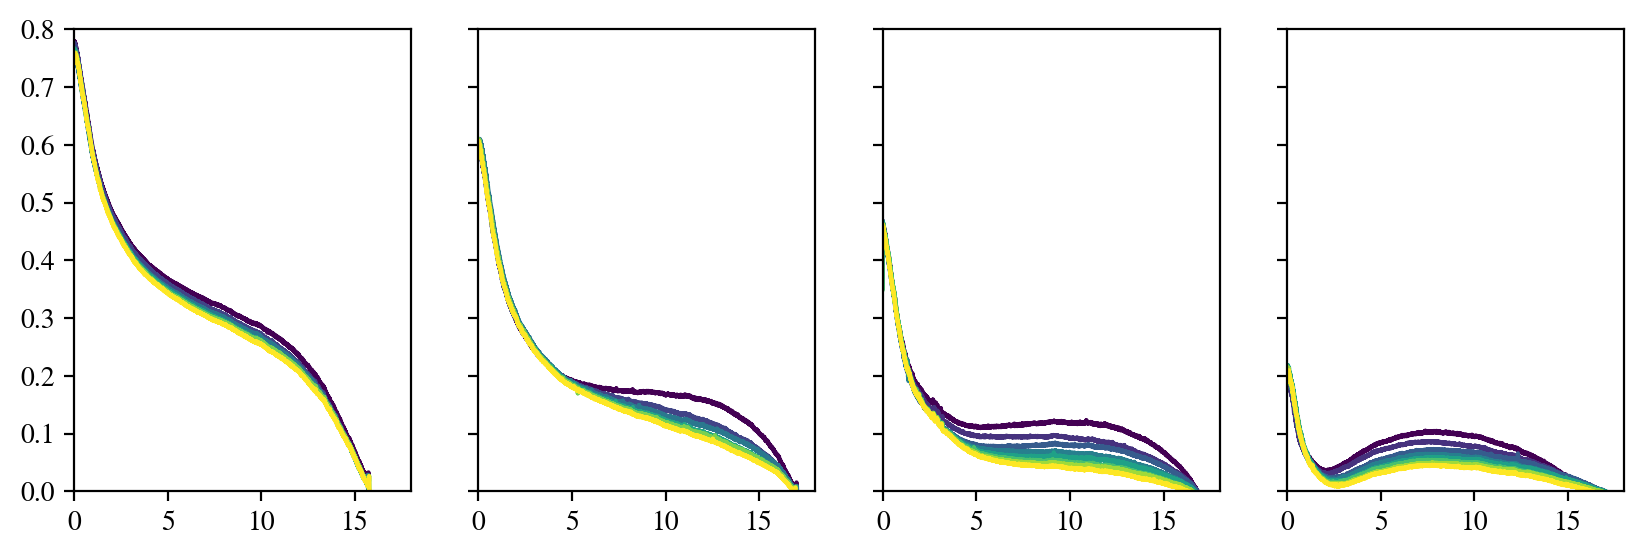

In [4]:
folder = r"E:\WPM\04292024\surface_profile"
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10,3), dpi=200)
for j in range(4):
    df = pd.read_csv(os.path.join(folder, "beet_scan4_{:d}.csv".format(j+1))).set_index("x")
    cmap = plt.get_cmap("viridis", df.shape[1])
    i = 0
    for scan in df:
        ax[j].plot(df.index, df[scan], color=cmap(i), label=i)
        i += 1
        ax[j].set_xlim([0,18])
        ax[j].set_ylim([0,0.8])
    # ax[j].legend(frameon=False)


## 7 Flow field

Use Tracker to track a few particles manually.

### 7.1 Velocity over time

Assume that in the proxy of the beet, the flow velocity is independent of position and is only a function of time. Note that this cannot be true, because we know the film is not uniform in thickness. If velocity is constant everywhere, fluid continuity cannot be satisfied. However, the flow rate change here is more drastic in time than in space, 

In [51]:
flow = pd.read_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_particle.txt", skiprows=2, sep=",").set_index("t")
flow.head()

,x,y,x.1,y.1,x.2,y.2,x.3,y.3,Unnamed: 9
t,,,,,,,,,
5.339,6.049,0.356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
vkey_list = []
for key in flow:
    if "x" in key:
        vkey = key.replace("x", "v")
        vkey_list.append(vkey)
        flow[vkey] = np.nan
        flow.loc[flow[key].dropna().index, vkey] = (flow[key].dropna().diff()) / (flow[key].dropna().index.diff().values)

In [53]:
v_mean = flow[vkey_list].mean(axis=1).dropna()

Text(0, 0.5, 'Flow velocity, v (mm/s)')

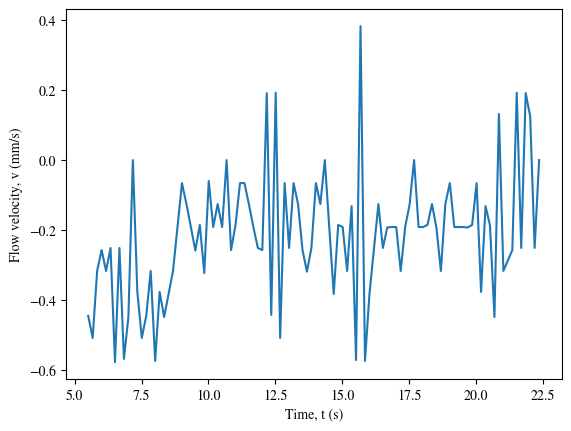

In [54]:
plt.plot(v_mean)
plt.xlabel("Time, t (s)")
plt.ylabel("Flow velocity, v (mm/s)")

In [55]:
v_mean.abs().to_frame("Velocity").to_csv(r"E:\WPM\04292024\flow_field_hand_track\beet_scan4_4_flow-time.csv")

Plot the velocity over time for the four scans.

In [78]:
folder = r"E:\WPM\04292024\flow_field_hand_track"
df_list = []
for i in range(4):
    df = pd.read_csv(os.path.join(folder, "beet_scan4_{:d}_flow-time.csv".format(i+1))).rename(columns={"Velocity": "v{:d}".format(i)})
    df["t"] -= df["t"].min()
    df_list.append(df.sort_values("t").set_index("t"))
dfall = pd.concat(df_list, names=["v1", "v2", "v3", "v4"], axis=1)

In [67]:
df.sort_values(by="t")

,t,Velocity
0,0.000,0.445783
1,0.167,0.508982
2,0.334,0.317365
3,0.501,0.257485
4,0.668,0.317365
...,...,...
94,16.183,0.251497
95,16.350,0.191617
96,16.517,0.125749
97,16.684,0.251497


<Axes: >

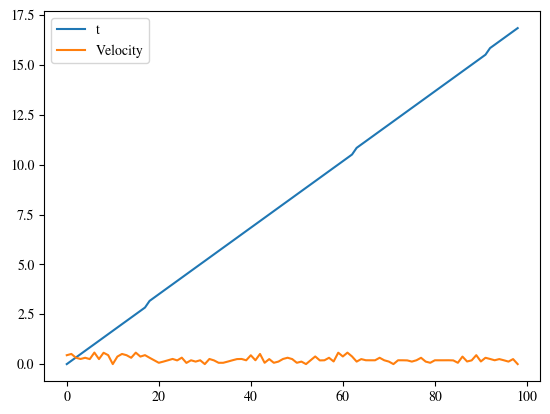

In [69]:
df.sort_values(by="t").plot()

(0.0, 6.0)

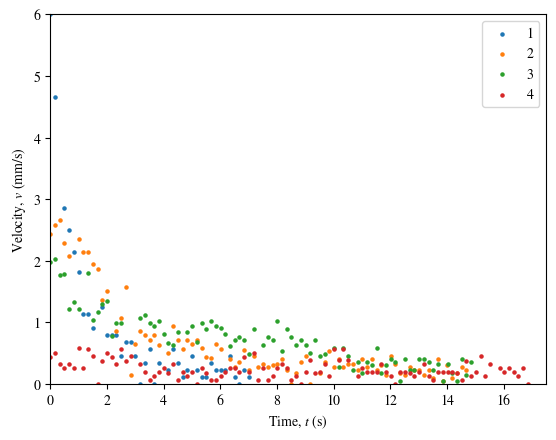

In [89]:
for key in dfall:
    plt.scatter(dfall.index, dfall[key], s=5)
plt.legend([1,2,3,4])
plt.xlabel("Time, $t$ (s)")
plt.ylabel("Velocity, $v$ (mm/s)")
plt.xlim([0,17.5])
plt.ylim([0,6])

In [82]:
dfall

,v0,v1,v2,v3
t,,,,
0.000,6.011976,2.431138,1.975904,0.445783
0.167,4.652695,2.580838,2.035928,0.508982
0.500,2.855422,2.287425,NaN,NaN
0.667,2.497006,2.077844,NaN,NaN
0.834,2.149701,NaN,NaN,NaN
...,...,...,...,...
16.183,NaN,NaN,NaN,0.251497
16.350,NaN,NaN,NaN,0.191617
16.517,NaN,NaN,NaN,0.125749


### 7.2 Spatial variation